<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/custom_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [14]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

In [15]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [17]:
data=pd.read_csv('./Peterpan_emo3.csv')
data=data.dropna(how='any')
print(f'Dimensions: {data.shape}')
data

Dimensions: (1697, 4)


,Unnamed: 0,sentence,posNeg,posNeg3
0,0,Chapter 1 PETER BREAKS THROUGH,0.000000,1.0
1,1,"All children, except one, grow up. They soon k...",0.311111,2.0
2,2,Of course they lived at 14 [their house number...,0.279545,2.0
3,3,The way Mr. Darling won her was this: the many...,0.483333,2.0
4,4,Mr. Darling used to boast to Wendy that her mo...,0.148889,1.0
...,...,...,...,...
1692,1692,"“If only I could go with you,” Wendy sighed.",0.000000,1.0
1693,1693,"“You see you can't fly,” said Jane.",0.800000,2.0
1694,1694,Of course in the end Wendy let them fly away t...,0.183333,2.0
1695,1695,"As you look at Wendy, you may see her hair bec...",0.097396,1.0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/MyDrive/PAB_test_ds/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/MyDrive/PAB_test_ds/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/MyDrive/PAB_test_ds/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6 files belonging to 2 classes.
Using 5 files for training.
Found 6 files belonging to 2 classes.
Using 1 files for validation.
Found 2 files belonging to 2 classes.


In [19]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'I really hate you.\n'
Label : 0 (neg)


# BERT

In [20]:
sentences=data['sentence'].tolist()
Y_data= data['posNeg3'].tolist()
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences[:500])
bert_results = bert(inputs)

In [21]:
print(bert_results.keys())

dict_keys(['sequence_output', 'default', 'pooled_output', 'encoder_outputs'])


In [22]:
# pooled_output 은 각 입력 시퀀스를 전체로 나타냅니다. 
# 모양은 [batch_size, H] 입니다. 이것은 전체 data에 대한 임베딩으로 생각할 수 있습니다.
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

#sequence_output 은 컨텍스트의 각 입력 토큰을 나타냅니다. 
# 모양은 [batch_size, seq_length, H] 입니다. 
# 이것을 data의 모든 토큰에 대한 문맥 삽입으로 생각할 수 있습니다. 
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(500, 768)
Pooled Outputs Values:[ 0.45421395  0.2949192   0.79641217  0.60480106  0.3280845   0.03076395
 -0.28662452 -0.61797523  0.7500393   0.03723879  0.5965795  -0.54139286]
Sequence Outputs Shape:(500, 128, 768)
Sequence Outputs Values:[[ 0.48999685  0.30394557  1.0887244  ...  1.848758    0.16467124
  -0.325687  ]
 [ 0.6065986  -0.47776282  0.2609226  ...  2.3007226  -0.37581712
  -0.05384592]
 [ 0.17835021  0.0432563   0.5358286  ...  1.7011096  -0.8225711
  -0.31128657]
 ...
 [ 0.44960898  0.07259469  0.03648981 ...  0.00718453 -1.6866527
  -0.32370418]
 [ 0.46865958 -0.03646746  0.08884454 ...  0.01199529 -1.8194145
  -0.43946   ]
 [ 0.44177595 -0.06479785  0.04875329 ...  0.06126611 -1.7820753
  -0.42757037]]


In [23]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [24]:
# classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

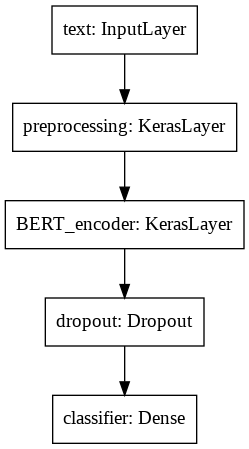

In [25]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [27]:
! pip install -q tf-models-official
from official.nlp import optimization

In [28]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [29]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [30]:
print(f'Training model with {BERT_MODEL}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/5
5/5 [==============================] - 16s 372ms/step - loss: 0.6295 - binary_accuracy: 0.5861 - val_loss: 0.1086 - val_binary_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 0s 96ms/step - loss: 0.0591 - binary_accuracy: 1.0000 - val_loss: 0.0118 - val_binary_accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 0s 96ms/step - loss: 0.0063 - binary_accuracy: 1.0000 - val_loss: 0.0031 - val_binary_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 0s 97ms/step - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 0.0017 - val_binary_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 0s 98ms/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 0.0014 - val_binary_accuracy: 1.0000


In [31]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')



2/2 [==============================] - 1s 28ms/step - loss: 7.7933e-04 - binary_accuracy: 1.0000
Loss: 0.0007793270633555949
Accuracy: 1.0


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


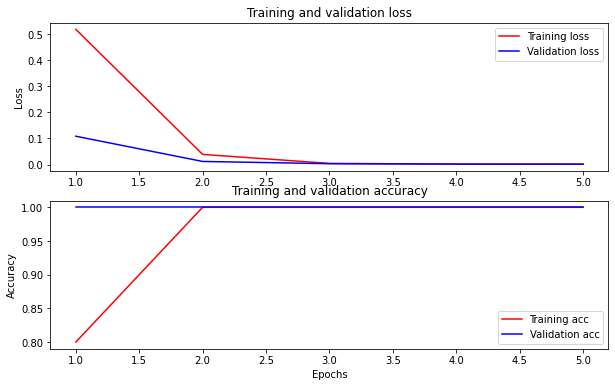

In [33]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')